In [1]:
import subprocess
import os
import scipy.io.wavfile as wav
import IPython
import matplotlib.pyplot as plt
import numpy as np
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
%matplotlib inline

In [2]:
ffmpeg_path = 'D:/Work/UpWork/Nicholas_Video/ffmpeg/bin/ffmpeg.exe'
wav_path = 'D:/Work/UpWork/Nicholas_Video/Wav'
raw_videos_path = 'D:/Work/UpWork/Nicholas_Video/RAW'
highlight_path = 'D:/Work/UpWork/Nicholas_Video/Highlights'

In [3]:
file_list = [f for f in os.listdir(raw_videos_path)]

In [4]:
command = [[ffmpeg_path,'-i', file, wav_path+'/'+os.path.splitext(file)[0]+'.wav'] for file in file_list]

In [5]:
for cmd in command:
    #Remove old wav files
    try:
        os.remove(wav_path+'/'+os.path.splitext(cmd[2])[0]+'.wav')  
    except OSError:
        pass
    process = subprocess.run(cmd, cwd=raw_videos_path)

In [6]:
wav_file_list = [w for w in os.listdir(wav_path) if w.endswith('.wav')]

In [7]:
def running_mean_same(x, N):
    cumsum = np.cumsum(np.hstack((np.zeros(int(N/2)),x,np.zeros(int(N/2))))) 
    return (cumsum[N:] - cumsum[:-N]) / N

In [8]:
def subsample(array, step):
    ssarray = array[::step].copy()
    return ssarray

In [9]:
def process_wav_files(wav_file_list):
    wav_array = []
    sample_rates = []
    for index, file in enumerate(wav_file_list):
        #Read wav file
        sample_rate, data = wav.read(wav_path+'/'+file)
        #Conver to mono channel
        data = data.astype(np.int32)
        data_mono = (data[:,0] + data[:,1])/2
        wav_duration = len(data)/sample_rate
        #window_length = window_slice * sample_rate
        sample_rates.append(sample_rate)
        wav_array.append(data_mono)
        #moving_average = np.convolve(abs(data_mono), np.ones((window_length,))/window_length, mode='same')
    return wav_array, sample_rates

In [10]:
def find_moving_average(sampled_data_array, sampling_rate_array, window_length, sampling_factor):
    moving_average = []
    for index, array in enumerate(sampled_data_array):
        wslice = int(window_length * sampling_rate_array[index]/sampling_factor)
        moving_average.append(running_mean_same(abs(sampled_data_array[index]), wslice))
    return moving_average

In [11]:
def find_energy(moving_average_list):
    energy = []
    for array in moving_average_list:
        energy.append(np.square(array))
    return energy

In [12]:
def plot_amp_vs_time(data, threshold):
    fig = plt.figure(figsize=(14, 10))
    ax1 = fig.add_subplot(211)
    plt.axhline(threshold, color="gray")
    ax1.set_xlabel('time')
    ax1.set_ylabel('Amplitude')
    ax1.plot(data)

In [13]:
def find_highlight_times(array, threshold, sample_rate):
    chunks = []
    for i in range(len(array)-1):
        if (array[i]<threshold<array[i+1] or array[i]>threshold>array[i+1]):
            chunks.append((i*SAMPLING_FACTOR/sample_rate))
    return chunks

In [14]:
def plot_histogram(histogram):
    bins = histogram[1]
    hist = histogram[0]
    center = (bins[:-1] + bins[1:]) / 2
    width = 0.7 * (bins[1] - bins[0])
    plt.bar(center, hist, align='center', width=width)
    plt.show()

In [15]:
wav_array, sample_rates = process_wav_files(wav_file_list)

In [31]:
SAMPLING_FACTOR = 4
WINDOW_LENGTH = 8
sampled_array = []
for array in wav_array:
    sampled_array.append(subsample(array, SAMPLING_FACTOR))
    moving_average = find_moving_average(sampled_array, sample_rates, WINDOW_LENGTH, SAMPLING_FACTOR)
    energy = find_energy(moving_average)

In [32]:
histograms = []
thresholds = []
for index, array in enumerate(energy):
    hist, bins = np.histogram(array)
    histograms.append((hist, bins))
    thresholds.append(bins[-7])

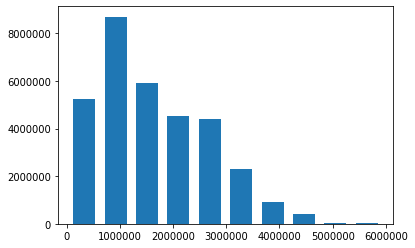

In [33]:
plot_histogram(histograms[1])

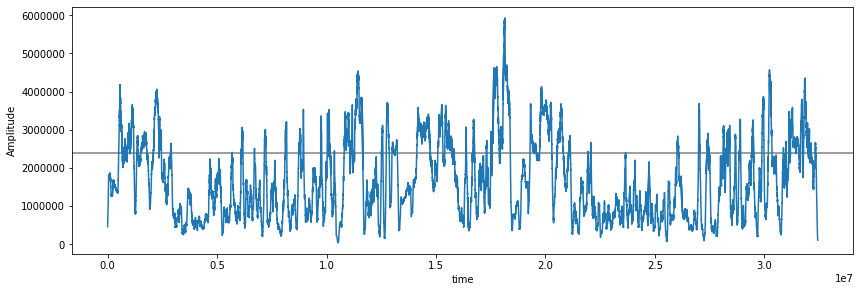

In [34]:
plot_amp_vs_time(energy[1], thresholds[1])

In [35]:
times = find_highlight_times(energy[1], thresholds[1], sample_rates[1])

In [36]:
chunk_list = []
total_highlight_time = 0
for index in range(0, len(times),2):
    difference = times[index+1]-times[index]
    if (difference > 4):
        chunk_list.append([times[index], times[index+1]])
        total_highlight_time = total_highlight_time + difference

In [37]:
chunk_list, total_highlight_time

([[42.392916666666665, 56.00208333333333],
  [62.431333333333335, 69.31808333333333],
  [75.229, 85.74766666666666],
  [86.081, 99.90391666666666],
  [111.11566666666667, 115.5115],
  [126.15933333333334, 149.38991666666666],
  [174.09133333333332, 195.67133333333334],
  [196.39516666666665, 205.02866666666668],
  [509.6864166666667, 515.328],
  [596.6785, 602.9068333333333],
  [676.0689166666667, 682.1374166666667],
  [730.2883333333333, 735.1794166666666],
  [840.1181666666666, 845.695],
  [900.2814166666667, 921.9483333333334],
  [925.6963333333333, 932.7281666666667],
  [939.958, 970.91625],
  [1043.0329166666668, 1047.6694166666666],
  [1060.6279166666666, 1071.885],
  [1082.4123333333334, 1088.6315],
  [1094.40475, 1102.7938333333334],
  [1177.19975, 1228.1210833333334],
  [1256.6834166666667, 1276.25875],
  [1283.0383333333334, 1311.4583333333333],
  [1389.9105833333333, 1395.9788333333333],
  [1463.78725, 1490.7601666666667],
  [1494.4985, 1533.0743333333332],
  [1607.906916666

['before.mp4', 'WWE.205.Live.2020.01.03.480p.x264-mSD[eztv].mkv']

In [60]:
file = open(highlight_path+'/highlight_file.txt','w') 
for index, chunk in enumerate(chunk_list):
    file.write('file '+'\''+highlight_path+'/'+'_highlight_'+str(index)+'.mkv'+'\''+'\n')
    ffmpeg_extract_subclip(raw_videos_path+'/'+file_list[1], int(chunk[0]), int(chunk[1]), targetname=highlight_path+'/'+'_highlight_'+str(index)+'.mkv')
file.close()


[MoviePy] Running:
>>> C:\Users\prate\Anaconda2\envs\python36\Library\bin\ffmpeg.exe -y -i D:/Work/UpWork/Nicholas_Video/RAW/WWE.205.Live.2020.01.03.480p.x264-mSD[eztv].mkv -ss 42.00 -t 14.00 -vcodec copy -acodec copy D:/Work/UpWork/Nicholas_Video/Highlights/_highlight_0.mkv
... command successful.

[MoviePy] Running:
>>> C:\Users\prate\Anaconda2\envs\python36\Library\bin\ffmpeg.exe -y -i D:/Work/UpWork/Nicholas_Video/RAW/WWE.205.Live.2020.01.03.480p.x264-mSD[eztv].mkv -ss 62.00 -t 7.00 -vcodec copy -acodec copy D:/Work/UpWork/Nicholas_Video/Highlights/_highlight_1.mkv
... command successful.

[MoviePy] Running:
>>> C:\Users\prate\Anaconda2\envs\python36\Library\bin\ffmpeg.exe -y -i D:/Work/UpWork/Nicholas_Video/RAW/WWE.205.Live.2020.01.03.480p.x264-mSD[eztv].mkv -ss 75.00 -t 10.00 -vcodec copy -acodec copy D:/Work/UpWork/Nicholas_Video/Highlights/_highlight_2.mkv
... command successful.

[MoviePy] Running:
>>> C:\Users\prate\Anaconda2\envs\python36\Library\bin\ffmpeg.exe -y -i D:/Wor

>>> C:\Users\prate\Anaconda2\envs\python36\Library\bin\ffmpeg.exe -y -i D:/Work/UpWork/Nicholas_Video/RAW/WWE.205.Live.2020.01.03.480p.x264-mSD[eztv].mkv -ss 1623.00 -t 8.00 -vcodec copy -acodec copy D:/Work/UpWork/Nicholas_Video/Highlights/_highlight_27.mkv
... command successful.

[MoviePy] Running:
>>> C:\Users\prate\Anaconda2\envs\python36\Library\bin\ffmpeg.exe -y -i D:/Work/UpWork/Nicholas_Video/RAW/WWE.205.Live.2020.01.03.480p.x264-mSD[eztv].mkv -ss 1644.00 -t 46.00 -vcodec copy -acodec copy D:/Work/UpWork/Nicholas_Video/Highlights/_highlight_28.mkv
... command successful.

[MoviePy] Running:
>>> C:\Users\prate\Anaconda2\envs\python36\Library\bin\ffmpeg.exe -y -i D:/Work/UpWork/Nicholas_Video/RAW/WWE.205.Live.2020.01.03.480p.x264-mSD[eztv].mkv -ss 1711.00 -t 23.00 -vcodec copy -acodec copy D:/Work/UpWork/Nicholas_Video/Highlights/_highlight_29.mkv
... command successful.

[MoviePy] Running:
>>> C:\Users\prate\Anaconda2\envs\python36\Library\bin\ffmpeg.exe -y -i D:/Work/UpWork/Ni

In [58]:
combine_videos_cmd = "ffmpeg -f concat -safe 0 -i highlight_file.txt -c copy highlight.mkv"

In [59]:
process = subprocess.run(combine_videos_cmd, cwd=highlight_path)